In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from SALib.analyze import sobol
import warnings
from ema_workbench.analysis import feature_scoring
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
    perform_experiments,
    Samplers,
    SequentialEvaluator,
)
# from dike_model_function import DikeNetwork 
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time
from ema_workbench.analysis import prim
from ema_workbench.em_framework.parameters import Constant
from Convience_fun import create_scenario
import multirange as mr
import pickle

warnings.filterwarnings("ignore")

## PRIM

In [2]:
# Initialize the model
dike_model, planning_steps = get_model_for_problem_formulation(6)
# create a dictionary in which all policies are zero
policy = {str(p): 0 for p in dike_model.levers}

# create a dataframe of the candidate strategies and drop unnecessary columns
policy_levers = pd.read_csv('data/policies_to_evaluate_scen0.csv')
policy_levers.drop(columns='Unnamed: 0', inplace=True)

# Create a Policy object for each policy and append to the list
policies = []
for index, row in policy_levers.iterrows():
    for p in policy_levers.columns:
        policy[p] = row[p]
    policies.append(Policy(f'Policy{index}', **policy))
# print(policies)

In [3]:
# Perform experiments
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(scenarios=1000,policies=policies,uncertainty_sampling=Samplers.LHS)

experiments, outcomes = results

100%|██████████████████████████████████████| 3000/3000 [04:09<00:00, 12.02it/s]


In [4]:
# Create a dataframe of the outcomes
df_outcomes = pd.DataFrame(outcomes)

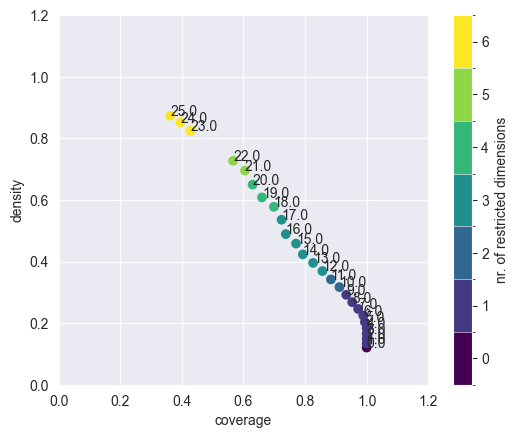

In [5]:
# Apply PRIM by taking the top 20th percentile of the Expected Number of Deaths 
# and the Expected Annual Damage for dike ring 5
x = experiments

y = ((df_outcomes["A.5_Expected Number of Deaths"] > list(np.sort(df_outcomes["A.5_Expected Number of Deaths"]))[np.int64(0.80* len(df_outcomes["A.5_Expected Number of Deaths"]))])
    |(df_outcomes['A.5_Expected Annual Damage'] > list(np.sort(df_outcomes['A.5_Expected Annual Damage']))[np.int64(0.80* len(df_outcomes['A.5_Expected Annual Damage']))]))

prim_alg = prim.Prim(x, y, threshold=0.8,peel_alpha=0.1)
box1 = prim_alg.find_box()
box1.show_tradeoff(annotated=True)
plt.show()

In [6]:
# (Manually) select a box that has a nice coverage and density
pd.DataFrame(box1.inspect(19, style='data')[0][1]).to_csv('data\A5_space_Prim3.csv')

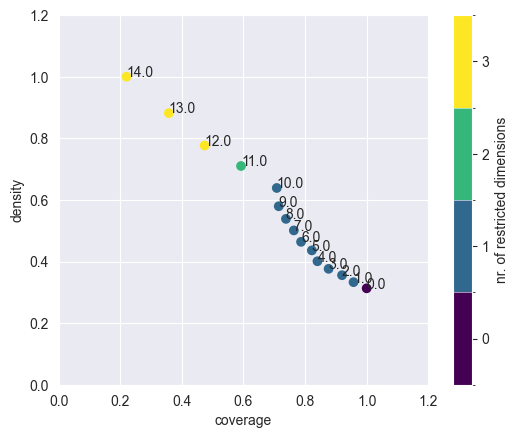

In [17]:
# Apply PRIM by taking the top 20th percentile of the Expected Number of Deaths 
# and the Expected Annual Damage for all dike rings
y = ((df_outcomes['Expected Number of Deaths'] > list(np.sort(df_outcomes["Expected Number of Deaths"]))[np.int64(0.80* len(df_outcomes['Expected Number of Deaths']))])
     |(df_outcomes['Expected Annual Damage'] > list(np.sort(df_outcomes["Expected Annual Damage"]))[np.int64(0.80* len(df_outcomes['Expected Annual Damage']))]))

prim_alg = prim.Prim(x, y, threshold=0.8,peel_alpha=0.1)
box2 = prim_alg.find_box()
box2.show_tradeoff(annotated=True)
plt.show()

In [18]:
# (Manually) select a box that has a nice coverage and density 
pd.DataFrame(box2.inspect(11, style='data')[0][1]).to_csv('data\All_space_Prim3.csv')

In [22]:
# Load the data from the selected PRIM boxes
df_param_space_A5 = (pd.read_csv('data/A5_space_Prim3.csv').drop(0).rename(columns={"Unnamed: 0": "Variable"}))
df_param_space_all = (pd.read_csv('data/All_space_Prim3.csv').drop(0).rename(columns={"Unnamed: 0": "Variable"}))

# Define a function that creates generates a scenario from each box
def create_scenario_from_box(all, a5):
    # Loop over the uncertainties and check whether the variable starts with a 'd'
    # As the variable 'discount rate' is categorical, the value 2.5 is chosen as the average after visual inspection
    para_list = []
    for uncertainty in dike_model.uncertainties:
        variable = uncertainty.name
        if variable.startswith("d"):
            para_list.append(2.5)
        # Else check if this uncertainty is a limiting factor for the A5 box 
        # and check if A5 box is the box we want to extract a scenario from
        elif (variable in list(df_param_space_A5.Variable)) & (a5 == True):
            # Determine the minimum and maximum value for this uncertainty
            min_1 = float(
                df_param_space_A5[df_param_space_A5['Variable'] == variable][df_param_space_A5.columns[1]].values[0])
            max_1 = float(
                df_param_space_A5[df_param_space_A5['Variable'] == variable][df_param_space_A5.columns[2]].values[0])
            
            # Append the average value to the para_list
            para_list.append((min_1 + (max_1 - min_1) / 2))
 
        # Else check if this uncertainty is a limiting factor for the Total box 
        # and check if Total box is the box we want to extract a scenario from
        elif (variable in list(df_param_space_all.Variable)) & (all == True):
            # Determine the minimum and maximum value for this uncertainty
            min_2 = float(
                df_param_space_all[df_param_space_all['Variable'] == variable][df_param_space_all.columns[1]].values[0])
            max_2 = float(
                df_param_space_all[df_param_space_all['Variable'] == variable][df_param_space_all.columns[2]].values[0])
            
            # Append the average value to the para_list
            para_list.append((min_2 + (max_2 - min_2) / 2))
        # Else check if the variable is equal to 'A.0_ID flood wave shape' and append the chosen average of 17
        elif variable == "A.0_ID flood wave shape":
            para_list.append(17)
        # Else check if the variable is equal to 'Brate' and append the chosen average of 1.5
        elif variable.endswith("Brate"):
            para_list.append(1.5)
        # If the uncertainty is not a constraining factor for the box, append the overall average
        else:
            para_list.append((uncertainty.lower_bound + (uncertainty.upper_bound - uncertainty.lower_bound) / 2))

    return create_scenario(para_list)

# Create a scenario for each box
Scenarios_MOEA = [create_scenario_from_box(all=True, a5=False), create_scenario_from_box(all=False, a5=True)]

# Create a file to store the results
with open("data\ScenMultiMORDM", 'wb') as file:
    pickle.dump(Scenarios_MOEA, file) 